In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.0 MB/s eta 0:00:00


Data shape: (1048575,)


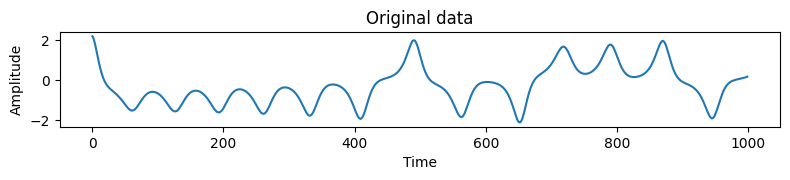

In [3]:
# @title Daat reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv

nan_indices = np.where(np.isnan(data))
data = np.delete(data, nan_indices)

# standardization
mean_value = np.mean(data)
std_dev = np.std(data)
data = (data - mean_value) / std_dev


print('Data shape:',data.shape)

#######
#Visualiation

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Input gate $i_t$,

Forget gate $f_t$,

$h$: Sigmoid and omit the biases:


\begin{equation*}
\begin{split}
i_t &= h(W_{\mathrm{datain}} d_t + W_{\mathrm{gatein}} c_{t-1}),\\
f_t &= h(W_{\mathrm{dataforget}} d_t + W_{\mathrm{forget}} c_{t-1}),\\
\tilde{c}_t &= \tanh\!\left(W_{\mathrm{dataout}} d_t + W_{\mathrm{gateout}} (f_t \odot c_{t-1})\right),\\
c_t &= (1 - i_t)\odot c_{t-1} + i_t \odot \tilde{c}_t,\\
x_t &= c_t
\end{split}
\end{equation*}




 The operator $\odot$ denotes the Hadamard product (element-wise product).

 ($W_{\mathrm{dataout}}$ and $W_{\mathrm{gateout}}$ must be corresponding to the candidate hidden state matrices.)

In [4]:
# @title Definition of GRU

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

 # Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low



# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def make_connection(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

####################
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def Reservoir(x_in,x,W):
        x =  np.tanh(np.dot(W, x) + x_in)
        return x

def Gate(x_in,x,W):
        x =  sigmoid(np.dot(W, x) + x_in)
        return x

#####################

def GRU(x,c,x_gatein,Wgatein,x_cell,Wcell,x_forget,Wforget,x_gateout,Wgateout):

        c_new = Reservoir(x_gateout,c * Gate(x_forget,c,Wforget),Wgateout)
        c = (1-Gate(x_gatein,c,Wgatein)) * c +Gate(x_gatein,c,Wgatein) *c_new

        #x = Gate(x_gateout,c,Wgateout) * np.tanh(c) #Peephole

        return x,c

####################
#Ridge Regression and  Output Weight Matrix
####################
def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        #X_pseudo_inv = np.linalg.inv(X_XT + beta * np.identity(N_x))
        #Wout_opt = np.dot(D_XT, X_pseudo_inv)
        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x,c, T_train,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len):

    x = np.zeros(N_x)
    c = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))


    for n in range(T_train):


            # reservoir state vector
        x,c = GRU(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

            # teacher data
        d = train_D[n,:]

        if n > discard_len:   # discard the first part of the data
            ##X_XT, D_XT = Ridge(d, x, X_XT, D_XT)
            X_XT, D_XT = Ridge(d, c, X_XT, D_XT)

    return X_XT, D_XT,x,c

########################
#induction formula for creating estimated data
########################

def run(test_U,x,c,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test):


    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        x,c = GRU(x,c,np.dot(Wdatain,y),Wgatein, np.dot(Wdatacell,y), \
                   Wcell,np.dot(Wdataforget,y),Wforget,np.dot(Wdataout,y),Wgateout)

        ##y_pred = np.dot(Wout, x)
        y_pred = np.dot(Wout, c)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [5]:
# @title Definition of Bayesian optimization of GRU

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))

################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 28)
    N_x = trial.suggest_int("N_x", Node, Node)
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density_gate = trial.suggest_float("density_gate", 0.01, 1)
    density_res = trial.suggest_float("density_res", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho_gate = trial.suggest_float("rho_gate", 0, 1.5)
    rho_res = trial.suggest_float("rho_res", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value_datain = trial.suggest_float("seed_value_datain", 0, 100)
    seed_value_gatein = trial.suggest_float("seed_value_gatein", 0, 100)
    seed_value_datacell = trial.suggest_float("seed_value_datacell", 0, 100)
    seed_value_cell = trial.suggest_float("seed_value_cell", 0, 100)
    seed_value_dataforget = trial.suggest_float("seed_value_dataforget", 0, 100)
    seed_value_forget = trial.suggest_float("seed_value_forget", 0, 100)
    seed_value_dataout = trial.suggest_float("seed_value_dataout", 0, 100)
    seed_value_gateout = trial.suggest_float("seed_value_gateout", 0, 100)

###############

    T_0 = T_train + lag * dim
###############
#Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

###############
#Convert data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)


    for i in range(dim):

        data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]


# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)
    c_special = np.zeros(N_x)

    X_XT, D_XT,x_special,c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

 # Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

##############################
#Calculate RMSE (we compare with TensorFlow)
##############################

    pred_D = np.zeros((T_train,dim), dtype=float)
    x = np.zeros(N_x)
    c = np.zeros(N_x)

    for n in range(T_train):

        x,c = GRU(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

        ##pred_D[n,:] = np.dot(Wout, x)
        pred_D[n,:] = np.dot(Wout, c)

    return np.sqrt(np.mean((pred_D[discard_len:]-train_D[discard_len:])**2))

1048575
CPU times: user 200 µs, sys: 0 ns, total: 200 µs
Wall time: 188 µs


In [6]:
# @title Implementation of Bayesian optimization of GRU

%%time

n_trials    = 30   # Number of times to test with optuna (generate RMSE for this number of times)
T_train     = 5000 # Training period
T_test      = 100  # Forecast period
Node        = 80   # Node

discard_len   = 10 # Number of steps not learned at the beginning (not important)
MAX_TRIALS  = 8    # Repeat the same thing while shifting each one step to produce robust result


test_num    = 3000 # Number of times for one test (to get one generalization error in MAE)
synchro_len = 70   #Steps to generate initial hidden layer vector

###################################

mean_score  = []
score       = []

###################################
#Convert data to Implement set for each trial

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")


    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials)

    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag  = trial.params["lag"]
    dim  = trial.params["dim"]
    N_x  = trial.params["N_x"]
    beta = trial.params["beta"]
    density_gate = trial.params["density_gate"]
    density_res = trial.params["density_res"]
    input_scale = trial.params["input_scale"]
    rho_gate    = trial.params["rho_gate"]
    rho_res     = trial.params["rho_res"]
    alpha       = trial.params["alpha"]
    seed_value_datain      = trial.params["seed_value_datain"]
    seed_value_gatein      = trial.params["seed_value_gatein"]
    seed_value_datacell    = trial.params["seed_value_datacell"]
    seed_value_cell        = trial.params["seed_value_cell"]
    seed_value_dataforget  = trial.params["seed_value_dataforget"]
    seed_value_forget      = trial.params["seed_value_forget"]
    seed_value_dataout     = trial.params["seed_value_dataout"]
    seed_value_gateout     = trial.params["seed_value_gateout"]

###################################
##Training phase
###################################
    #Test start time

    T_0 = T_train+lag*dim

    #Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

    #Convert training data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)

    for i in range(dim):

          data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

    #Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

    #Ridge
    X_XT, D_XT,x_special, c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

    #Generate output weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###################################
##Test phase
###################################

    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)

    #Convert test data to a delay coordinate system

    for t in range(test_num):

          for i in range(dim):

              data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                            :T_0+t+T_test-i*lag+1]
    # Initialization of test data

    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))


    ##The last time data of the training data output must overlap with the test data!

    x_conti = None
    for t in range(test_num):


        X_XT, D_XT,x_conti,c_conti =  train(data_delay[T_train-synchro_len :T_train,:,t], \
                                    data_delay[T_train-synchro_len+1:T_train+1,:,t],np.zeros(N_x),np.zeros(N_x),synchro_len,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,0)


        #Predictive data generation

        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_conti,c_conti,Wdatain,Wgatein,Wdatacell, \
                                      Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test)

        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1
                                :T_train+T_test+1,0,t]


    mae = MAE( test_Y[T_test-1,:],test_D[T_test-1,:])

    score.append(mae)
    mean_score.append(np.mean(score))

    print('MAE:',mae)
    print('Average of MAE:',np.mean(score))


[I 2025-08-25 01:38:11,489] A new study created in memory with name: no-name-29197fa5-c7e5-491f-975e-1d786417b7d5


Trial 1/8


[I 2025-08-25 01:38:13,571] Trial 0 finished with value: 0.0020831302046051296 and parameters: {'lag': 5, 'dim': 4, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4164173307549027, 'density_res': 0.9153985244686031, 'input_scale': 0.170410441058723, 'rho_gate': 1.4775617209028895, 'rho_res': 0.09164246614106636, 'alpha': 0.6966912870732771, 'seed_value_datain': 53.29280649789199, 'seed_value_gatein': 97.59316869544075, 'seed_value_datacell': 91.53222691217965, 'seed_value_cell': 53.17324838973616, 'seed_value_dataforget': 57.910075549526354, 'seed_value_forget': 97.81232895024802, 'seed_value_dataout': 98.18908172307688, 'seed_value_gateout': 0.128724147883863}. Best is trial 0 with value: 0.0020831302046051296.
[I 2025-08-25 01:38:15,510] Trial 1 finished with value: 0.027510147137881663 and parameters: {'lag': 5, 'dim': 27, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.23414900147688347, 'density_res': 0.26166344771463657, 'input_scale': 0.4717187861353452, 'rho_gate': 0.702142079498569

Best trial:
  'params': {'lag': 3, 'dim': 3, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4151230990739777, 'density_res': 0.31932159738690985, 'input_scale': 0.5582281257134, 'rho_gate': 0.41396464714364595, 'rho_res': 0.29091193883502175, 'alpha': 0.453889111036071, 'seed_value_datain': 82.00565908009037, 'seed_value_gatein': 56.38762733200266, 'seed_value_datacell': 43.86313229699699, 'seed_value_cell': 81.87819826496855, 'seed_value_dataforget': 61.80262058888213, 'seed_value_forget': 15.542550960674916, 'seed_value_dataout': 95.24677882337406, 'seed_value_gateout': 39.15125523165873},
  'value': 0.0019966256666467163,


[I 2025-08-25 01:39:34,855] A new study created in memory with name: no-name-444fcc9f-00eb-4bd6-8510-730d7a07e86f


MAE: 0.4444167815970242
Average of MAE: 0.4444167815970242
Trial 2/8


[I 2025-08-25 01:39:35,594] Trial 0 finished with value: 0.08361480801906873 and parameters: {'lag': 7, 'dim': 23, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.8679285177294179, 'density_res': 0.4636616701786174, 'input_scale': 1.1917005498538737, 'rho_gate': 0.6242506388853024, 'rho_res': 1.0236569425754307, 'alpha': 0.0066327907852608, 'seed_value_datain': 77.2669342668031, 'seed_value_gatein': 77.9362433616502, 'seed_value_datacell': 79.75380569549564, 'seed_value_cell': 68.01661921050342, 'seed_value_dataforget': 13.02979638130094, 'seed_value_forget': 4.781945878458194, 'seed_value_dataout': 75.73371560264046, 'seed_value_gateout': 31.305976003696934}. Best is trial 0 with value: 0.08361480801906873.
[I 2025-08-25 01:39:36,344] Trial 1 finished with value: 0.00460914193374244 and parameters: {'lag': 3, 'dim': 25, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.04634128719307834, 'density_res': 0.5338109237479552, 'input_scale': 0.43263464293693127, 'rho_gate': 1.0139481700662336, 'rh

Best trial:
  'params': {'lag': 3, 'dim': 3, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.36872815241920065, 'density_res': 0.637491006893869, 'input_scale': 0.9531615279679551, 'rho_gate': 1.4887600940405408, 'rho_res': 1.4902025365746545, 'alpha': 0.5493875337901446, 'seed_value_datain': 31.23387687653121, 'seed_value_gatein': 97.96068629318707, 'seed_value_datacell': 27.92490106749214, 'seed_value_cell': 67.95190736270506, 'seed_value_dataforget': 34.16358073172358, 'seed_value_forget': 54.79021541675061, 'seed_value_dataout': 1.5981318708525984, 'seed_value_gateout': 69.41674921918934},
  'value': 0.001935317250543764,


[I 2025-08-25 01:40:39,418] A new study created in memory with name: no-name-db163fa0-137a-49bb-83b4-a7f4c779d616


MAE: 0.42707039065473223
Average of MAE: 0.4357435861258782
Trial 3/8


[I 2025-08-25 01:40:40,604] Trial 0 finished with value: 0.018293375434433615 and parameters: {'lag': 5, 'dim': 24, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.8543468787336062, 'density_res': 0.6472823328683805, 'input_scale': 0.4530249419793951, 'rho_gate': 0.349774351543441, 'rho_res': 1.2607034183274952, 'alpha': 0.8879160005396299, 'seed_value_datain': 42.16035356586577, 'seed_value_gatein': 13.736846247639434, 'seed_value_datacell': 11.48980610900735, 'seed_value_cell': 88.52847352085483, 'seed_value_dataforget': 48.208939457623046, 'seed_value_forget': 85.68307537975336, 'seed_value_dataout': 12.802694567307816, 'seed_value_gateout': 89.03291610672751}. Best is trial 0 with value: 0.018293375434433615.
[I 2025-08-25 01:40:41,835] Trial 1 finished with value: 0.03519568552437291 and parameters: {'lag': 6, 'dim': 21, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.21485975687424191, 'density_res': 0.1379783530138407, 'input_scale': 0.6842996209483115, 'rho_gate': 0.848336115864095, 

Best trial:
  'params': {'lag': 4, 'dim': 3, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.9244389155480986, 'density_res': 0.3085087528888127, 'input_scale': 0.32119145958495776, 'rho_gate': 0.8699666569637778, 'rho_res': 0.4129157440248931, 'alpha': 0.1416720456476043, 'seed_value_datain': 38.485606881007996, 'seed_value_gatein': 81.38722979946547, 'seed_value_datacell': 12.526124708192633, 'seed_value_cell': 13.554025649493123, 'seed_value_dataforget': 0.09080984140433657, 'seed_value_forget': 70.21723013675492, 'seed_value_dataout': 56.94671958809084, 'seed_value_gateout': 84.35252992448474},
  'value': 0.0020451668508994422,


[I 2025-08-25 01:41:46,954] A new study created in memory with name: no-name-103cd915-773e-4357-8574-f6b04044d6d0


MAE: 0.4217958531316168
Average of MAE: 0.43109434179445777
Trial 4/8


[I 2025-08-25 01:41:47,710] Trial 0 finished with value: 0.0035011826999498037 and parameters: {'lag': 5, 'dim': 7, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.1152082665093789, 'density_res': 0.018938648801329255, 'input_scale': 1.4022926972076935, 'rho_gate': 0.8151079743351008, 'rho_res': 0.5908267466609549, 'alpha': 0.813237851098453, 'seed_value_datain': 56.55144697290865, 'seed_value_gatein': 77.9617056469045, 'seed_value_datacell': 8.713677918763118, 'seed_value_cell': 66.38311142296229, 'seed_value_dataforget': 84.29997741293425, 'seed_value_forget': 39.50881476161771, 'seed_value_dataout': 48.29979701007016, 'seed_value_gateout': 6.372279078325615}. Best is trial 0 with value: 0.0035011826999498037.
[I 2025-08-25 01:41:48,446] Trial 1 finished with value: 0.0032443286265545586 and parameters: {'lag': 5, 'dim': 18, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4385115988280796, 'density_res': 0.9544428070829398, 'input_scale': 0.24903541254051054, 'rho_gate': 1.2970892847903177

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.7661919554307722, 'density_res': 0.4948288643939464, 'input_scale': 0.22233339849282716, 'rho_gate': 1.3265535620371391, 'rho_res': 0.1818537560911251, 'alpha': 0.19430005747143536, 'seed_value_datain': 8.144973845883, 'seed_value_gatein': 9.43288721472496, 'seed_value_datacell': 86.84687281080537, 'seed_value_cell': 77.19359536957629, 'seed_value_dataforget': 24.951670545078624, 'seed_value_forget': 61.22193015838999, 'seed_value_dataout': 85.87151472967182, 'seed_value_gateout': 19.262026734749345},
  'value': 0.0017819720039421625,


[I 2025-08-25 01:42:56,040] A new study created in memory with name: no-name-fbd7dc0c-7de8-49f3-952a-67f6d7ec6953


MAE: 0.3605601637737635
Average of MAE: 0.4134607972892842
Trial 5/8


[I 2025-08-25 01:42:57,551] Trial 0 finished with value: 0.09977043898195011 and parameters: {'lag': 7, 'dim': 24, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.32420142980380123, 'density_res': 0.6202923699349767, 'input_scale': 1.2900602439763242, 'rho_gate': 0.6149791514929304, 'rho_res': 1.1735983146078066, 'alpha': 0.2424897412566609, 'seed_value_datain': 47.96068078281389, 'seed_value_gatein': 27.779627452065945, 'seed_value_datacell': 16.077193236285193, 'seed_value_cell': 7.063919290693443, 'seed_value_dataforget': 75.16776100264585, 'seed_value_forget': 89.99725345852964, 'seed_value_dataout': 99.22569123943047, 'seed_value_gateout': 6.503483443948232}. Best is trial 0 with value: 0.09977043898195011.
[I 2025-08-25 01:42:58,813] Trial 1 finished with value: 0.003006186475639377 and parameters: {'lag': 6, 'dim': 12, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.12293029224758807, 'density_res': 0.2160384594832544, 'input_scale': 0.07978315932150898, 'rho_gate': 0.2384419393479617

Best trial:
  'params': {'lag': 3, 'dim': 6, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.37675268510074517, 'density_res': 0.1854902506375328, 'input_scale': 0.46598867702549596, 'rho_gate': 1.1691360992466757, 'rho_res': 0.1729658719982198, 'alpha': 0.4286994250365513, 'seed_value_datain': 34.602879384371114, 'seed_value_gatein': 55.62566074815388, 'seed_value_datacell': 15.497951790715701, 'seed_value_cell': 64.1536494673016, 'seed_value_dataforget': 61.25439666739729, 'seed_value_forget': 24.976765499793906, 'seed_value_dataout': 12.309026243669862, 'seed_value_gateout': 90.6941072965769},
  'value': 0.0017739619275206526,


[I 2025-08-25 01:44:04,538] A new study created in memory with name: no-name-a7d84b5f-f0c2-4b4c-accb-fbd49415742b


MAE: 0.1194697540683749
Average of MAE: 0.35466258864510236
Trial 6/8


[I 2025-08-25 01:44:05,248] Trial 0 finished with value: 0.0019090014634888296 and parameters: {'lag': 3, 'dim': 11, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.7928268859921067, 'density_res': 0.49678112297928806, 'input_scale': 0.2970568187828906, 'rho_gate': 0.2779531077362537, 'rho_res': 0.3540478127944443, 'alpha': 0.994901579207976, 'seed_value_datain': 54.26446974253894, 'seed_value_gatein': 13.8364833528121, 'seed_value_datacell': 44.11471592714239, 'seed_value_cell': 45.00976997082864, 'seed_value_dataforget': 12.203781402419756, 'seed_value_forget': 27.36843189348943, 'seed_value_dataout': 50.81035324043348, 'seed_value_gateout': 44.14816782649158}. Best is trial 0 with value: 0.0019090014634888296.
[I 2025-08-25 01:44:05,977] Trial 1 finished with value: 0.02618460212890278 and parameters: {'lag': 4, 'dim': 17, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.3175301031823627, 'density_res': 0.6291122670311247, 'input_scale': 1.4460742013100458, 'rho_gate': 0.34723263861769527,

Best trial:
  'params': {'lag': 3, 'dim': 5, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.7899609739848739, 'density_res': 0.5314538096024657, 'input_scale': 0.30148018055278486, 'rho_gate': 1.3746562759156729, 'rho_res': 0.7743379974729514, 'alpha': 0.905605727120304, 'seed_value_datain': 6.356470993206813, 'seed_value_gatein': 51.16847917522631, 'seed_value_datacell': 23.864551581004328, 'seed_value_cell': 73.09576479632456, 'seed_value_dataforget': 70.5942820322996, 'seed_value_forget': 62.45259225773518, 'seed_value_dataout': 92.088248702339, 'seed_value_gateout': 56.92201622781934},
  'value': 0.0017455910062981915,


[I 2025-08-25 01:45:12,926] A new study created in memory with name: no-name-efd1b0ca-c238-4ebc-87e2-442adffbc759


MAE: 0.1117494284907372
Average of MAE: 0.31417706195270817
Trial 7/8


[I 2025-08-25 01:45:13,649] Trial 0 finished with value: 0.0019349772981960703 and parameters: {'lag': 3, 'dim': 10, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.4298607213567391, 'density_res': 0.393361855223861, 'input_scale': 0.19873147737769115, 'rho_gate': 0.24415064144758547, 'rho_res': 1.4140754212511535, 'alpha': 0.07079298299553227, 'seed_value_datain': 0.2676596033679979, 'seed_value_gatein': 88.1082721166954, 'seed_value_datacell': 69.62604784976426, 'seed_value_cell': 75.85548827515545, 'seed_value_dataforget': 47.34943223590082, 'seed_value_forget': 50.20892804773472, 'seed_value_dataout': 61.38282427992584, 'seed_value_gateout': 95.7764459817524}. Best is trial 0 with value: 0.0019349772981960703.
[I 2025-08-25 01:45:14,392] Trial 1 finished with value: 0.0023397397040689975 and parameters: {'lag': 5, 'dim': 17, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.3430344188689251, 'density_res': 0.24651044530611957, 'input_scale': 0.16908632536766888, 'rho_gate': 0.0708631213428

Best trial:
  'params': {'lag': 3, 'dim': 5, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.1492767987161836, 'density_res': 0.48888111294783937, 'input_scale': 0.6381344112120224, 'rho_gate': 0.5808008526146425, 'rho_res': 0.5731657160184906, 'alpha': 0.24370377523679107, 'seed_value_datain': 25.053942753722083, 'seed_value_gatein': 61.22056321614555, 'seed_value_datacell': 43.85120207217835, 'seed_value_cell': 23.177284838291936, 'seed_value_dataforget': 10.620458670779556, 'seed_value_forget': 68.31046437648617, 'seed_value_dataout': 4.914902843741084, 'seed_value_gateout': 88.80365742016514},
  'value': 0.0018745541458945164,


[I 2025-08-25 01:46:18,440] A new study created in memory with name: no-name-ce13eff5-1697-40a6-b6fd-f0cda28bcc89


MAE: 0.14279090903665645
Average of MAE: 0.2896933258218436
Trial 8/8


[I 2025-08-25 01:46:19,197] Trial 0 finished with value: 0.011729668196268157 and parameters: {'lag': 3, 'dim': 24, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.2466219417576619, 'density_res': 0.9203941877867577, 'input_scale': 0.7652975662202959, 'rho_gate': 1.0450534861580365, 'rho_res': 0.5127629726382604, 'alpha': 0.8116794613651557, 'seed_value_datain': 42.49600295809933, 'seed_value_gatein': 51.36518903822046, 'seed_value_datacell': 75.70097976280744, 'seed_value_cell': 46.33961604514101, 'seed_value_dataforget': 8.353209356081226, 'seed_value_forget': 69.86202774697082, 'seed_value_dataout': 54.739945431010696, 'seed_value_gateout': 69.17657046841724}. Best is trial 0 with value: 0.011729668196268157.
[I 2025-08-25 01:46:19,945] Trial 1 finished with value: 0.07940056208659108 and parameters: {'lag': 8, 'dim': 21, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.8628273509574876, 'density_res': 0.5551741928711237, 'input_scale': 1.2028996763243025, 'rho_gate': 0.18852451806259074, 

Best trial:
  'params': {'lag': 3, 'dim': 9, 'N_x': 80, 'beta': 0.0001, 'density_gate': 0.5383338252568873, 'density_res': 0.7458905391722652, 'input_scale': 0.4557776682481687, 'rho_gate': 1.2646169883640217, 'rho_res': 0.3196499014784824, 'alpha': 0.7767519992677799, 'seed_value_datain': 39.643354402170644, 'seed_value_gatein': 24.132430998933927, 'seed_value_datacell': 29.289354249960002, 'seed_value_cell': 18.861725435242782, 'seed_value_dataforget': 90.61137085731288, 'seed_value_forget': 1.8296455472899709, 'seed_value_dataout': 11.598510222324258, 'seed_value_gateout': 16.588684072021422},
  'value': 0.001871515197809991,
MAE: 0.15015259519984292
Average of MAE: 0.27225073449409354
CPU times: user 9min 18s, sys: 4.82 s, total: 9min 23s
Wall time: 9min 22s


Average of MAE: 0.27225073449409354


/tmp/ipython-input-2762027289.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


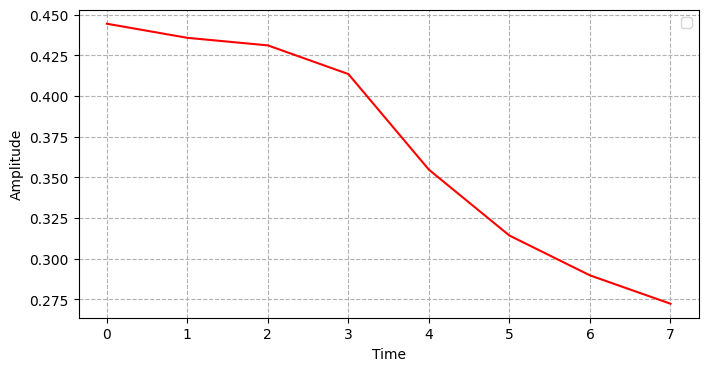

In [7]:
# @title Result of GRU prediction

mean_score = np.array(mean_score)

import matplotlib.pyplot as plt

print('Average of MAE:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE(the last trial): 0.15015259519984292
forecast period: 100


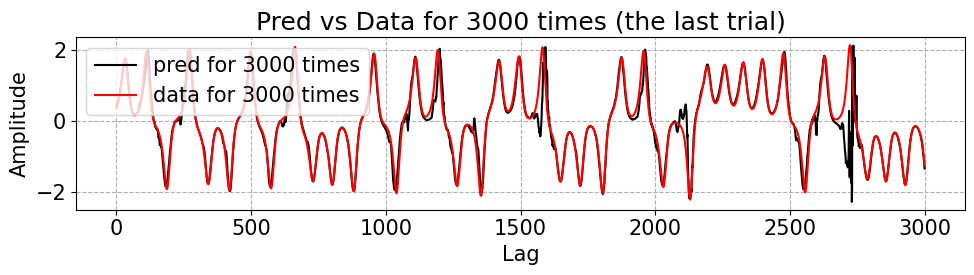

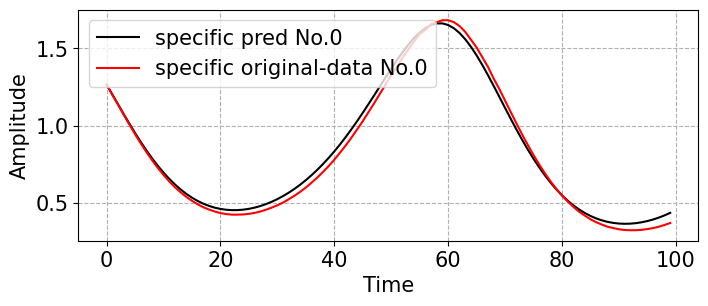

In [8]:
# @title Visualization (only the last trial)

print("MAE(the last trial):", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.title(f"Pred vs Data for {test_num} times (the last trial)")
plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 3))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()